## Set Up

In [97]:
# connect to google drive
import os
import numpy as np

# mount google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [98]:
# Check for GPU free memory
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
#!pip install psutil
#!pip install humanize
import psutil
import humanize
import GPUtil as GPU
GPUs = GPU.getGPUs()

# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print('='*40)
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
  print('='*40)
printm() 

shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
The folder you are executing pip from can no longer be found.
Gen RAM Free: 9.8 GB  | Proc size: 5.2 GB
GPU RAM Free: 10554MB | Used: 4525MB | Util  30% | Total 15079MB


In [99]:
# change root directory such that models are saved in google drive during training
root_dir = "/content/gdrive/My Drive/NLP/MT_ENSP"
os.chdir(root_dir)
!ls

code_utils		   NMT_model		      sanity_check_en_es_data
collect_submission.sh	   NMT_model_mul_atten	      sanity_check.py
Debugging.ipynb		   NMT_model_mul_atten.optim  Tensor_file.log
en_es_data		   NMT_model.optim	      test_output.txt
gpu_requirements.txt	   nmt_model.py		      TheTransformer.ipynb
__init__.py		   __pycache__		      utils.py
local_env.yml		   README.md		      vocab.json
Machine_Translation.ipynb  run.py		      vocab.py
model_embeddings.py	   run.sh


## Imports

In [0]:
# insert the path for utility custom functions
import sys
sys.path.insert(0, os.path.join(root_dir, 'code_utils'))

# custom python functions and classes
from utils import read_corpus, batch_iter, pad_sents
from vocab import Vocab, VocabEntry

In [0]:
# basic packages
import math
import time
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

seaborn.set_context(context="talk")
%matplotlib inline


from collections import Counter, namedtuple
from docopt import docopt
from itertools import chain
import json
from typing import List, Tuple, Dict, Set, Union
from docopt import docopt

#pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence
from torch.autograd import Variable



#others
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction
from tqdm import tqdm
from IPython.core.debugger import set_trace

In [0]:
# Logger

import logging
logger = logging.getLogger("tensor_tracker")

file_handler = logging.FileHandler("Tensor_file.log")
stream_handler = logging.StreamHandler()
formatter = logging.Formatter('%(message)s')

file_handler.setFormatter(formatter)
stream_handler.setFormatter(formatter)

logger.addHandler(file_handler)

#logger.addHandler(stream_handler)

logger.setLevel(logging.DEBUG)

# A helper function to check how tensor sizes change
def log_size(tsr: torch.Tensor, name: str):
    #cls = getclass()
    logger.debug(msg=f"{name} ==> size={tsr.shape}")

## Load data and EDA

In [103]:
# load data
train_es = 'en_es_data/train.es'
train_en = 'en_es_data/train.en'

dev_es = 'en_es_data/dev.es'
dev_en = 'en_es_data/dev.en'

test_es = 'en_es_data/test.es'
test_en = 'en_es_data/test.en'


train_data_src = read_corpus(train_es, source='src')
train_data_tgt = read_corpus(train_en, source='tgt')

dev_data_src = read_corpus(dev_es, source='src')
dev_data_tgt = read_corpus(dev_en, source='tgt')

test_data_src = read_corpus(test_es, source='src')
test_data_tgt = read_corpus(test_en, source='tgt')

train_data = list(zip(train_data_src,train_data_tgt))
dev_data = list(zip(dev_data_src,dev_data_tgt))
test_data = list(zip(test_data_src,test_data_tgt))

#
print("=="*40)
print("Number of examples in train: {}".format(len(train_data)))
print("Number of examples in valid: {}".format(len(dev_data)))
print("Number of examples in test: {}".format(len(test_data)))
#
print("=="*40)
print("Spanish --> English")
es, en = next(iter(dev_data))
print("Sp: {}".format(' '.join(es)))
print("En: {}".format(' '.join(en)))
print("=="*40)


## Build Vocab
# Build Vocab with train set

size = 50000
freq_cutoff= 2
vocab_file = 'en_es_data/vocab.json'

vocab = Vocab.build(train_data_src, train_data_tgt, size, freq_cutoff)
print('generated vocabulary, source %d words, target %d words' % (len(vocab.src), len(vocab.tgt)))

vocab.save(vocab_file)
print('vocabulary saved to %s' % vocab_file)

#
print("=="*40)
print('Note that the <s> and </s> tokens are added while vocab\
      initialization.\nThese tokens are also present in target\
      top frequent words. \nThat is why vocab size for target language is lesser by 2.')
print("=="*40)


# Check tokenization process
print("=="*40)
sents = [['I', 'asgjsssd', 'will', 'be', 'there', 'for', 'you.'], ['This', 'is', 'spartaaaaaaaa.']]
print("Tokenize:\n {} \n {}\n".format(' '.join(sents[0]), ' '.join(sents[1])))

print(vocab.tgt.to_input_tensor(sents, "cpu"))
#
print("=="*40)
print("Note that 3 and 0  are <unk> and <pad> tokens!")
print("=="*40)

Number of examples in train: 216617
Number of examples in valid: 851
Number of examples in test: 8064
Spanish --> English
Sp: El ao pasado proyect estas dos diapositivas para demostrar que la capa de hielo rtico, que durante los ltimos tres millones de aos ha sido del tamao de los 48 estados, se ha reducido en un 40 por ciento.
En: <s> Last year I showed these two slides so that  demonstrate that the arctic ice cap,  which for most of the last three million years  has been the size of the lower 48 states,  has shrunk by 40 percent. </s>
initialize source vocabulary ..
number of word types: 172418, number of word types w/ frequency >= 2: 80623
initialize target vocabulary ..
number of word types: 128873, number of word types w/ frequency >= 2: 64215
generated vocabulary, source 50004 words, target 50002 words
vocabulary saved to en_es_data/vocab.json
Note that the <s> and </s> tokens are added while vocab      initialization.
These tokens are also present in target      top frequent wor

## Develop

### Scaled dot product attention

In [0]:
class Attention(nn.Module):
  """Compute attention vectors for each time step"""
  def __init__(self, dropout_rate = 0.1):
    super(Attention, self).__init__()
    self.dropout = nn.Dropout(dropout_rate)
    
  def forward(self, Q, K, V, mask = None):
    """ Compute attention at each seq position in a batch
    @ param Q:  Tensor(batch, seq_len_1, d_k)
    @ param K:  Tensor(batch, seq_len_2, d_k)
    @ param V:  Tensor(batch, seq_len_2, d_v)
    @ param mask: Tensor(batch, 1, seq_len_2) or None: contains 0 at the location of pad/mask
    @ returns attn_vec: Tensor(batch, seq_len_2, d_v): weighted attention values at each seq location 
    """
    d_k = K.size(-1) # dimension of query and key
    assert Q.size(-1) == d_k, "Query and Key dimensions must be same"
    
    # compute dot product between queeries and keys for each batch and position 
    # attn (b, i, j): how much (self) attention the query at seq location i should pay to key, value at seq location j for observation b
    attn = torch.bmm(Q,K.transpose(-2,-1)) #(batch, seq_len_1, d_k) * (batch, d_k, seq_len_2) : (batch, seq_len_1, seq_len_2) 
    
    # Fill attention weight with large negative value where padding (or mask) is used: attn score will be ~ 0 for pad after softmax
    # set_trace()
    if mask is not None:
      #mask = mask.unsqueeze(dim=-2)
      attn = attn.masked_fill(mask == 0, -1e9)
      #set_trace()
      
    ## NB: masked_fill ==> fills elements of self tensor with value where mask is one. 
    ##The shape of mask must be broadcastable with the shape of the underlying tensor.
    
    # normalize the att by sqrt(d_k): for better scaling of values as d_k bocomes large, 
    ##else large activation values would be in small gradient range of softmax 
    attn = attn/math.sqrt(d_k)
    
    # Allpy softmax along last dim i.e normalize the attn values for each query location
    attn = F.softmax(attn, dim = -1)
    
    # Apply dropout (during train)
    attn = self.dropout(attn)
    
    # Compute self attn vector using attn and values 
    attn_vec = torch.bmm(attn, V) # (batch, seq_len_1, seq_len_2) * (batch, seq_len_2, d_v) : (batch, seq_len_1, d_v)
    
    return attn_vec

In [105]:
attn_mech = Attention()

batch, seq_len, d_k, d_v = 16, 5, 256, 512
Q = torch.rand(batch, seq_len, d_k)
K = torch.rand(batch, seq_len, d_k)
V = torch.rand(batch, seq_len, d_v)

#mask = torch.tensor(np.zeros((batch,seq_len))) # mask everything
#mask[:,0] = 1

attn_vec = attn_mech(Q,K,V)
print('shape = {}'.format(attn_vec.shape)) #(batch, seq_len, d_v) 


shape = torch.Size([16, 5, 512])


### Attention Head

In [0]:
class AttentionHead(nn.Module):
  def __init__(self, d_model, d_k, d_v, dropout_rate = 0.1):
    super(AttentionHead, self).__init__()
    
    self.d_model = d_model
    self.d_k = d_k
    self.d_v = d_v
    # Layers
    self.Q_proj = nn.Linear(d_model, d_k)
    self.K_proj = nn.Linear(d_model, d_k)
    self.V_proj = nn.Linear(d_model, d_v) # Note: d_k = d_v will be used 
    self.attn = Attention(dropout_rate)
    
  def forward(self, Q_model, K_model, V_model, mask = None):
    """ Project model queries, keys, and values into a sub space and computes attention vectors
    param Q_model: Tensor(batch, seq_len, d_model)
    param K_model: Tensor(batch, seq_len, d_model)
    param V_model: Tensor(batch, seq_len, d_model)
    param mask: Tensor(batch, seq_len) or None: contains 0 at the location of pad/mask
    returns attn_vec: Tensor(batch, seq_len, d_feature)
    """
    
    Q = self.Q_proj(Q_model)
    K = self.K_proj(K_model) 
    V = self.V_proj(V_model)
    
    attn_vec = self.attn(Q,K,V, mask) #(batch, seq_len, d_v)
    
    return attn_vec

In [107]:
# basic sanity check
batch, seq_len, d_model, d_k, d_v = 16, 5, 64, 8, 24

Q_model = torch.rand(batch, seq_len, d_model)
K_model = torch.rand(batch, seq_len, d_model)
V_model = torch.rand(batch, seq_len, d_model)

head = AttentionHead(d_model,d_k, d_v)

attn_vec = head(Q_model,K_model,V_model)
attn_vec.shape #(batch, seq_len, d_v)

torch.Size([16, 5, 24])

### Multi-Head Attention

In [0]:
class MultiHeadAttention(nn.Module):
  def __init__(self, n_head, d_model, dropout_rate = 0.1):
    super(MultiHeadAttention, self).__init__()
    
    # attributes
    assert d_model % n_head == 0, "No of attention heads need to be a factor of model dimension"
    self.n_head = n_head
    self.d_model = d_model # model dimensions
    self.d_k =  d_model // n_head
    self.d_v = self.d_k # edit this if dim(value) != dim(key)
    
    # layers
    self.attn_heads = nn.ModuleList([AttentionHead(self.d_model, self.d_k, self.d_v, dropout_rate) for i in range(n_head)])
    
    self.projection = nn.Linear(self.n_head*self.d_v, d_model)
    
  def forward(self, Q_model, K_model, V_model, mask=None):
    
    """ Perform multi-headed attention on model query, key, value
    param Q_model: Tensor (batch, seq_len, d_model)
    param K_model: Tensor (batch, seq_len, d_model)
    param V_model: Tensor (batch, seq_len, d_model)
    returns X: Tensor(batch, seq_len, d_model) : self-attention values at each position of sequence
    """
    
    values = [attn_head(Q_model, K_model, V_model, mask) for i, attn_head in enumerate(self.attn_heads)] 
    # list containing nHead tensors of shape (batch, seq_len, d_v)
    
    X = torch.cat(values, dim = -1) # (batch, seq_len, nHead*d_v)
    X = self.projection(X) #(batch, seq_len, d_model)
    
    return X
    

In [109]:
# basic sanity check
batch, seq_len, d_model, n_head = 16, 5, 64, 8

Q_model = torch.rand(batch, seq_len, d_model)
K_model = torch.rand(batch, seq_len, d_model)
V_model = torch.rand(batch, seq_len, d_model)

multi_head = MultiHeadAttention(n_head, d_model)

attn_vec = multi_head(Q_model,K_model,V_model)
attn_vec.shape #(batch, seq_len, d_model)

torch.Size([16, 5, 64])

### Feed Forward

In [0]:
class FeedForward(nn.Module):
  def __init__(self, d_model, d_hidden, dropout_rate = 0.1):
    super(FeedForward, self).__init__()
    
    # layers
    self.ff1 = nn.Linear(d_model, d_hidden)
    self.ff2 = nn.Linear(d_hidden, d_model)
    self.dropout = nn.Dropout(dropout_rate)
    
  def forward(self, x):
    """ Position wise feed forward with two linear layers
    @ param x: Tensor (batch, d_model): attention value output 
    @ return out: Tensor(batch,d_model)
    """
    x = F.relu(self.ff1(x))
    out = self.ff2(self.dropout(x))
    return out

### Layer Norm

In [0]:
class LayerNorm(nn.Module):
  def __init__(self, d_model, eps =1e-6):
    super(LayerNorm, self).__init__()
    
    # attributes
    self.beta = nn.Parameter(torch.zeros(d_model)) # mean of transformed features
    self.gamma = nn.Parameter(torch.ones(d_model)) # sd
    self.eps = eps
     
  def forward(self,x):
    """ returns layer norm
    @ param x: Tensor (batch, d_model)
    @ returns x_tf : Tensor (batch,d_model)
    """
    mean = x.mean(-1, keepdim = True) #(batch,1)
    std = x.std(-1, keepdim = True)   #(batch,1)
    x_tf = self.gamma*(x-mean)/(std+self.eps) + self.beta #[(d_model)]*[(batch,d_model) - (batch,1)]/(batch,1) + [(d_model)]
    return x_tf
    

In [112]:
# basic sanity check
d_model = 256
batch = 16
x = torch.zeros(batch,d_model)
layerNorm = LayerNorm(d_model)
x_tr = layerNorm(x)
x_tr.shape

torch.Size([16, 256])

###  Embeddings

In [0]:
class Embeddings(nn.Module):
  
  def __init__(self, vocab_size, d_model, pad_index= None):
    super(Embeddings, self).__init__()
    
    self.d_model = d_model
    self.vocab_size = vocab_size
    #layer
    self.LUT = nn.Embedding(vocab_size, d_model, padding_idx = pad_index)
    
  def forward(self, x):
    """ Get the embedding for x
    @ param x: tokes (batch, seq_len)
    @ return x_embed (batch, seq_len, x_embed)
    """
    x_embed = self.LUT(x)*math.sqrt(self.d_model)
    return x_embed
  
## Positional encoding
class PositionalEncoding(nn.Module):
  
  def __init__(self, d_model, max_len = 1024):
    super(PositionalEncoding, self).__init__()
    #self.d_model = d_model
    #set_trace()
    
    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0,max_len).unsqueeze(dim=1).float() #(max_len,1)
    div_term = torch.exp(-torch.arange(0, d_model, 2).float() * (math.log(10000.0) / d_model))
    
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    
    pe = pe.unsqueeze(0) #(1,max_len,d_model)
    # unsqueezed at dim 0 to enable broadcasting along batch dimension
    self.weight = nn.Parameter(pe, requires_grad=False)
    
  def forward(self, x):
    """ Returns positional encoding for a input sequence 
    @ param x: Tensor (batch, seq_len)
    @ returns positional encoding of shape (batch, seq_len, d_model)
    """
    return self.weight[:, :x.size(1), :] # (1, seq_len, d_model) 
  
  
## Final embeddings
class NetEmbedding(nn.Module):
  def __init__(self, vocab_size, d_model, pad_index = None, dropout_rate = 0.1):
    super(NetEmbedding, self).__init__()

    # layers
    self.reg_embed = Embeddings(vocab_size, d_model, pad_index)
    self.pos_embed = PositionalEncoding(d_model)
    self.dropout = nn.Dropout(dropout_rate)

  def forward(self,x):
    """ Final embeddings for a input sequence
    @ param x: input sequence Tensor (batch, seq_len)
    @ returns x_next : corresponding net embeddings (batch, seq_len, d_model)
    """
    #set_trace()
    x_net = self.reg_embed(x) + self.pos_embed(x) #(batch,seq_len,d_model) + (1,seq_len,d_model)
    return self.dropout(x_net)


In [114]:
get_embed = NetEmbedding(50000,512)
x = torch.tensor([np.arange(5), np.arange(5)])
x_embed = get_embed(x)
x_embed.dtype

torch.float32

### Residual Connection

In [0]:
class ResConnect(nn.Module):
  
  def __init__(self, d_model, dropout_rate=0.1):
    super(ResConnect, self).__init__()
    self.layer_norm = LayerNorm(d_model)
    self.dropout = nn.Dropout(dropout_rate)
    
  def forward(self, x, x_mapped):
    x_out = x + self.dropout(self.layer_norm(x_mapped))
    return x_out

### One Encoder Block

In [0]:
class EncoderBlock(nn.Module):
  
  def __init__(self, n_head =8, d_model=512, d_hidden=2084, dropout_rate = 0.1):
    
    super(EncoderBlock, self).__init__()
    
    self.attn_head = MultiHeadAttention(n_head, d_model, dropout_rate)
    self.connect_1 = ResConnect(d_model, dropout_rate)
    self.connect_2 = ResConnect(d_model, dropout_rate)
    self.dropout = nn.Dropout(dropout_rate)
    self.feedforward = FeedForward(d_model, d_hidden, dropout_rate)
    
  def forward(self, x, mask= None):
    """
    One encoder block which will be cloned N times for total encoder block
    @ param x: Tensor(batch, seq_len, d_model)
    @ param mask: Tensor (batch, 1, seq_len)
    @ returns encoded x_out with self attention and feed forward
    """
    attn = self.attn_head(x, x, x, mask=mask) #(batch, seq_len, d_model)
    
    # Apply first normalization and residual connection
    x = self.connect_1(x, attn)
    
    # point-wise feed forward
    x_ff = self.feedforward(x)
    
    # apply second normalization and residual connection
    x_out = self.connect_2(x, x_ff)
    
    return x_out
    

## Encoder

In [0]:
class Encoder(nn.Module):
  
  def __init__(self, n_blocks = 6, n_head = 8, d_model = 512, d_hidden = 2048, dropout_rate = 0.1):
    super(Encoder, self).__init__()
    
    #self.n_blocks = n_blocks
    self.encoders = nn.ModuleList([EncoderBlock(n_head,d_model,d_hidden,dropout_rate) for i in range(n_blocks)])
    self.layernorm = LayerNorm(d_model)
    
  def forward(self, x, mask=None):
    
    """ The Encoder module
    @ param x: Tensor(batch, seq_len, d_model)
    @ param mask: Tensor(batch, 1, seq_len) with zeros at loacations of padding or intended mask
    @ returns encoded x to be used for decoding: Tensor(batch, seq_len, d_model)
    """
    for encoder in self.encoders:
      x = encoder(x, mask)
      
    return self.layernorm(x)

### Decoder Block

In [0]:
class DecoderBlock(nn.Module):
  
  def __init__(self, n_head =8, d_model=512, d_hidden=2084, dropout_rate = 0.1):
    super(DecoderBlock, self).__init__()
    
    self.masked_attn_head = MultiHeadAttention(n_head, d_model, dropout_rate) # decoder self-attention
    self.attn_head = MultiHeadAttention(n_head, d_model, dropout_rate) # encoder-decoder attention
    self.feedforward = FeedForward(d_model, d_hidden, dropout_rate)
    
    self.connect_1 = ResConnect(d_model, dropout_rate)
    self.connect_2 = ResConnect(d_model, dropout_rate)
    self.connect_3 = ResConnect(d_model, dropout_rate)

    self.dropout = nn.Dropout(dropout_rate)
    
  def forward(self, x, enc_out, src_mask= None, tgt_mask = None):
    """ Decoder block to be cloned N times
    @ param x: decoded seq Tensor (batch, tgt_len, d_model)
    @ param enc_out: encoded input sequence of shape (batch, src_len, d_model)
    @ param src_mask: Tensor(batch, 1, src_len) with zero at padding token ??
    @ param tgt_mask: Tensor (batch, tgt_len, tgt_len) with zeros s.t. tgt_mask[:, i, i+1:] = 0
    @ returns decoded x of shape (batch, tgt_len, d_model)
    """
    
    # Apply self-attention to decoder sequence with taget masking to prevent left side information flow
    attn = self.masked_attn_head(x, x, x, mask = tgt_mask)
    
    # Apply first residual connection    
    x = self.connect_1(x, attn)
    
    # Apply encoder-decoder attention
    attn = self.attn_head(Q_model = x, K_model = enc_out, V_model = enc_out, mask=src_mask)
    
    # Apply second residual connection
    x = self.connect_2(x, attn)
    
    # Apply position-wise feedforward network
    x_ff = self.feedforward(x)
    
    # Apply third residual connection
    x = self.connect_3(x, x_ff)
    
    return x

## Decoder

In [0]:
class Decoder(nn.Module):
  
  def __init__(self, n_blocks = 6, n_head = 8, d_model = 512, d_hidden = 2048, dropout_rate = 0.1):
    super(Decoder, self).__init__()
    
    #self.n_blocks = n_blocks
    self.decoders = nn.ModuleList([DecoderBlock(n_head,d_model,d_hidden,dropout_rate) for i in range(n_blocks)])
    self.layernorm = LayerNorm(d_model)
    
  def forward(self, x, enc_out, src_mask = None, tgt_mask = None):
    
    """ The Encoder module
    @ param x: Tensor(batch, seq_len, d_model)
    @ param mask: Tensor(batch, 1, seq_len) with zeros at loacations of padding or intended mask
    @ returns encoded x to be used for decoding: Tensor(batch, seq_len, d_model)
    """
    for decoder in self.decoders:
      x = decoder(x, enc_out, src_mask, tgt_mask)
      
    return self.layernorm(x)

In [0]:
## Function to create tgt_mask
def subsequent_mask(tgt_len):
    "Mask out subsequent positions."
    attn_shape = (1, tgt_len, tgt_len)
    
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8') # upper triangular matrix
    
    return torch.from_numpy(subsequent_mask) == 0 ## ByteTensor

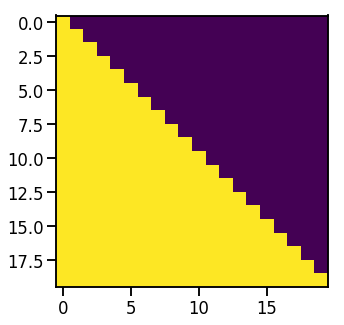

In [55]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])
None

In [121]:
mask = subsequent_mask(20)[0]
print(mask.dtype)

torch.uint8


### Generator

In [0]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, vocab_size, d_model):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

## Encoder-Decoder

In [0]:
class EncoderDecoder(nn.Module):
  """ Final model architecture """
  def __init__(self, vocab, encoder, decoder, src_embed, tgt_embed, generator):
    super(EncoderDecoder, self).__init__()
    
    self.vocab = vocab
    self.encoder = encoder
    self.decoder = decoder
    self.src_embed = src_embed
    self.tgt_embed = tgt_embed
    self.generator = generator
  
  def forward(self, source, target):
    """ Attention Is All You Need
    @ param src: source sentences List[List [str]]
    @ param tgt: target sentences List[List[str]]
    @ returns scores: a variable/tensor of shape (batch, ) representing the
      log-likelihood of generating the gold-standard target sentence 
    """
    
    source_padded = self.vocab.src.to_input_tensor(source, device=self.device)   # Tensor: (src_len, batch)
    target_padded = self.vocab.tgt.to_input_tensor(target, device=self.device)   # Tensor: (tgt_len, batch)
    
    #set_trace()
    
    src, tgt = source_padded.transpose(0,1), target_padded.transpose(0,1) # (batch, seq_len)
    tgt_in = tgt[:, :-1] # Chop of the <END> token for max length sentences.
    tgt_out = tgt[:, 1:] # Right Shift of target for prediction
    
    src_mask = self.generate_src_mask(src)
    tgt_mask_in = self.generate_tgt_mask(tgt_in)
    
    enc_out = self.encode(src, src_mask)
    dec_out = self.decode(enc_out, src_mask, tgt_in, tgt_mask_in) #(batch, tgt_len, d_model)
    pred_sents = self.generator(dec_out) #(batch, tgt_len, tgt_vocab_size)
    
    P = F.log_softmax(pred_sents, dim=-1) #(batch, tgt_len, tgt_vocab_size)
    # Zero out, probabilities for which we have nothing in the target text
    tgt_mask_out = (tgt_out != self.vocab.tgt['<pad>']).float() #(batch, tgt_len)
    
    # Compute log probability of generating true target words
    target_gold_words_log_prob = torch.gather(P, index= tgt_out.unsqueeze(-1), dim=-1).squeeze(-1) * tgt_mask_out #(batch, tgt_len)
    scores = target_gold_words_log_prob.sum(dim=-1)
    
    return scores
  
  
    
  def encode(self, src, src_mask):
    """ Encoder for source sentences """
    
    x_embed = self.src_embed(src) # (batch, src_len, d_model)
    enc_out = self.encoder(x_embed, src_mask)
    return enc_out
  
  def decode(self, enc_out, src_mask, tgt, tgt_mask):
    """ Decoder for translation """
    tgt_embed = self.tgt_embed(tgt)
    dec_out = self.decoder(tgt_embed, enc_out, src_mask, tgt_mask)
    return dec_out
  
  def generate_src_mask(self, src):
    """ create mask for source sentences 
    @ param src: padded source sentences tensor of shape (batch, src_len)
    @ returns src_mask: Tensor(batch, 1, src_len)    
    """
    pad_id = self.vocab.src['<pad>']
    src_mask = (src != pad_id).unsqueeze(-2)  #Tensor(batch, 1, src_len)
    
    return src_mask
  
  def generate_tgt_mask(self, tgt):
    """ create mask for source sentences 
    @ param tgt: padded target sentences tensor of shape (batch, tgt_len)
    @ returns tgt_mask: Tensor(batch, tgt_len, tgt_len)    
    """
    #set_trace()
    pad_id = self.vocab.tgt['<pad>']
    pad_mask = (tgt != pad_id).unsqueeze(-2)  #Tensor(batch, 1, tgt_len)
    
    tgt_len = tgt.size(-1)
    attn_shape = (1, tgt_len, tgt_len)
    
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8') # upper triangular matrix

    subsequent_mask = torch.tensor(subsequent_mask, device= self.device) == 0
    
    #subsequent_mask = torch.from_numpy(subsequent_mask) == 0 ## ByteTensor (1, tgt_len, tgt_len)
    
    tgt_mask = (pad_mask & subsequent_mask) #(batch, tgt_len, tgt_len)
    
    return tgt_mask
  
  
  @property
  def device(self):
    return self.src_embed.reg_embed.LUT.weight.device
  
  @staticmethod
  def load(model_path: str):
    """ Load the model from a file.
    @param model_path (str): path to model
    """
    params = torch.load(model_path, map_location=lambda storage, loc: storage)
    args = params['args']
    model = NMT(vocab=params['vocab'], **args)
    model.load_state_dict(params['state_dict'])

    return model

  def save(self, path: str):
      """ Save the odel to a file.
      @param path (str): path to the model
      """
      print('save model parameters to [%s]' % path, file=sys.stderr)

      params = {
          'args': dict(dropout_rate=self.dropout_rate),
          'vocab': self.vocab,
          'state_dict': self.state_dict()
      }

      torch.save(params, path)

In [0]:
## Create model
def make_model(vocab, n_blocks=6, n_head=8, d_model=512, d_hidden=2048, dropout_rate = 0.1):
  """ Create the model
  @ vocab: Vocab object
  """
  src_vocab = vocab.src # VocabEntry object
  src_vocab_size = len(src_vocab)
  src_pad_index = vocab.src['<pad>']
  
  tgt_vocab = vocab.tgt # VocabENtry object
  tgt_vocab_size = len(tgt_vocab)
  tgt_pad_index = vocab.tgt['<pad>']
  
  src_embed = NetEmbedding(src_vocab_size, d_model, src_pad_index, dropout_rate)
  tgt_embed = NetEmbedding(tgt_vocab_size, d_model, tgt_pad_index, dropout_rate)
  
  encoder = Encoder(n_blocks, n_head, d_model, d_hidden, dropout_rate)
  decoder = Decoder(n_blocks, n_head, d_model, d_hidden, dropout_rate)
  generator = Generator(tgt_vocab_size, d_model)
  
  model = EncoderDecoder(vocab, encoder, decoder, src_embed, tgt_embed, generator)
  
  # Initialization
  for p in model.parameters():
    if p.dim() > 1:
      nn.init.xavier_uniform_(p)
  
  return model

## Model functions

In [125]:
# load data
train_es = 'en_es_data/train.es'
train_en = 'en_es_data/train.en'

dev_es = 'en_es_data/dev.es'
dev_en = 'en_es_data/dev.en'

test_es = 'en_es_data/test.es'
test_en = 'en_es_data/test.en'


train_data_src = read_corpus(train_es, source='src')
train_data_tgt = read_corpus(train_en, source='tgt')

dev_data_src = read_corpus(dev_es, source='src')
dev_data_tgt = read_corpus(dev_en, source='tgt')

test_data_src = read_corpus(test_es, source='src')
test_data_tgt = read_corpus(test_en, source='tgt')

train_data = list(zip(train_data_src,train_data_tgt))
dev_data = list(zip(dev_data_src,dev_data_tgt))
test_data = list(zip(test_data_src,test_data_tgt))

## Build Vocab
# Build Vocab with train set

size = 50000
freq_cutoff= 2
vocab_file = 'en_es_data/vocab.json'

vocab = Vocab.build(train_data_src, train_data_tgt, size, freq_cutoff)
print('generated vocabulary, source %d words, target %d words' % (len(vocab.src), len(vocab.tgt)))

vocab.save(vocab_file)
print('vocabulary saved to %s' % vocab_file)


initialize source vocabulary ..
number of word types: 172418, number of word types w/ frequency >= 2: 80623
initialize target vocabulary ..
number of word types: 128873, number of word types w/ frequency >= 2: 64215
generated vocabulary, source 50004 words, target 50002 words
vocabulary saved to en_es_data/vocab.json


In [0]:
## Evaluation metric
def evaluate_ppl(model, dev_data, batch_size=32):
    """ Evaluate perplexity on dev sentences
    @param model (NMT): NMT_char Model
    @param dev_data (list of (src_sent, tgt_sent)): list of tuples containing source and target sentence
    @param batch_size (batch size)
    @returns ppl (perplixty on dev sentences)
    """
    was_training = model.training
    model.eval()

    cum_loss = 0.
    cum_tgt_words = 0.

    # no_grad() signals backend to throw away all gradients
    with torch.no_grad():
        for src_sents, tgt_sents in batch_iter(dev_data, batch_size):
            loss = -model(src_sents, tgt_sents).sum()

            cum_loss += loss.item()
            tgt_word_num_to_predict = sum(len(s[1:]) for s in tgt_sents)  # omitting leading `<s>`
            cum_tgt_words += tgt_word_num_to_predict

        ppl = np.exp(cum_loss / cum_tgt_words)

    if was_training:
        model.train()

    return ppl

In [0]:
## Train

def train_model(model, optimizer, clip_grad =5.0, max_epoch =30, max_patience = 3, max_trial = 3, lr_decay = 0.5, train_batch_size = 64, log_every = 100, valid_niter = 1000):
  
  
  print('Training begins...')
  ## Temp variables
  num_trial = 0
  train_iter = patience = cum_loss = report_loss = cum_tgt_words = report_tgt_words = 0
  cum_examples = report_examples  = valid_num = 0
  hist_valid_scores = []
  train_time = begin_time = time.time()
  
  # put the model in training mode
  model.train()
  
  # iterate over the epochs
  for epoch in range(max_epoch):
    for src_sents, tgt_sents in batch_iter(train_data, batch_size=train_batch_size, shuffle=True):
        
        train_iter += 1
        optimizer.zero_grad()
        batch_size = len(src_sents)
        
        example_losses = -model(src_sents, tgt_sents)
        batch_loss = example_losses.sum()
        loss = batch_loss/batch_size
        loss.backward() # autograd
        
        # Clip gradient
        grad_norn = torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
        optimizer.step() # update parameters
        
        batch_losses_val = batch_loss.item()
        report_loss += batch_losses_val
        cum_loss += batch_losses_val
        
        tgt_words_num_to_predict = sum(len(s[1:]) for s in tgt_sents)  # omitting leading `<s>`
        report_tgt_words += tgt_words_num_to_predict
        cum_tgt_words += tgt_words_num_to_predict
        report_examples += batch_size
        cum_examples += batch_size
        
        # print interim report about training
        
        if train_iter % log_every == 0:
            #set_trace()
            print('| Epoch %d, Iter %d| Avg Loss = %.2f| Avg. ppl = %.2f| Speed %.2f words/sec| Time %.2f min|' % (epoch+1, train_iter, report_loss / report_examples, math.exp(report_loss / report_tgt_words),
                                                                                     report_tgt_words / (time.time() - train_time), (time.time() - begin_time)/60.0))

            train_time = time.time()
            report_loss = report_tgt_words = report_examples = 0.
        
        # validation
        if train_iter % valid_niter == 0:
            
            print('| <Train Summary> | Epoch %d, Iter %d| Cum. loss = %.2f| Cum. ppl = %.2f|' % (epoch+1, train_iter, cum_loss / cum_examples, np.exp(cum_loss / cum_tgt_words)))

            cum_loss = cum_examples = cum_tgt_words = 0.
            valid_num += 1

            print('Report on validation set:', file=sys.stderr)

            # compute dev. ppl and bleu
            dev_ppl = evaluate_ppl(model, dev_data, batch_size=128)   # dev batch size can be a bit larger
            valid_metric = -dev_ppl

            print('Validation:  Dev. ppl = %f' % (dev_ppl), file=sys.stderr)

            
            # learning rate scheduling
            
            is_better = (len(hist_valid_scores) == 0 or valid_metric > max(hist_valid_scores))
            hist_valid_scores.append(valid_metric)

            if is_better:
                patience = 0
                print('Save currently the best model to [%s]' % model_save_path, file=sys.stderr)
                model.save(model_save_path)

                # also save the optimizers' state
                torch.save(optimizer.state_dict(), model_save_path + '.optim')
                
            elif patience < int(max_patience):
                patience += 1
                print('Hit patience %d' % patience, file=sys.stderr)

                if patience == int(max_patience):
                    num_trial += 1
                    print('Hit #%d trial' % num_trial, file=sys.stderr)
                    
                    if num_trial == int(max_trial):
                        print('early stop!', file=sys.stderr)
                        return

                    # decay lr, and restore from previously best checkpoint
                    lr = optimizer.param_groups[0]['lr'] * float(lr_decay)
                    print('load previously best model and decay learning rate to %f' % lr, file=sys.stderr)

                    # load model
                    params = torch.load(model_save_path, map_location=lambda storage, loc: storage)
                    model.load_state_dict(params['state_dict'])
                    model = model.to(device)

                    print('restore parameters of the optimizers', file=sys.stderr)
                    optimizer.load_state_dict(torch.load(model_save_path + '.optim'))

                    # set new lr
                    for param_group in optimizer.param_groups:
                        param_group['lr'] = lr

                    # reset patience
                    patience = 0

            if epoch +1 == int(max_epoch):
                print('Training stopped <-> Reached maximum number of epochs!', file=sys.stderr)
                return

## Training 

In [137]:
# initialize the model
# model = NMT_char(embed_size= 256, hidden_size=256, dropout_rate=0.3, vocab=vocab)
model = make_model(vocab)

# define model saving path
model_save_path = 'Transformer_model.pt'

# transfer the model to cuda if available
device = torch.device("cuda:0" if torch.cuda.device_count()>0 else "cpu")
print('Use device: %s' % device, file=sys.stderr)
model = model.to(device)

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)




# train parameters
max_epoch =30
train_batch_size = 16

# train the model
train_model(model, optimizer, max_epoch =max_epoch, train_batch_size = train_batch_size)

Use device: cuda:0


Training begins...
| Epoch 1, Iter 100| Avg Loss = 129.05| Avg. ppl = 1769.42| Speed 783.35 words/sec| Time 0.59 min|
| Epoch 1, Iter 200| Avg Loss = 119.88| Avg. ppl = 933.72| Speed 797.53 words/sec| Time 1.17 min|
| Epoch 1, Iter 300| Avg Loss = 117.11| Avg. ppl = 755.65| Speed 798.74 words/sec| Time 1.76 min|
| Epoch 1, Iter 400| Avg Loss = 119.72| Avg. ppl = 708.43| Speed 825.36 words/sec| Time 2.35 min|
| Epoch 1, Iter 500| Avg Loss = 118.01| Avg. ppl = 655.88| Speed 821.33 words/sec| Time 2.94 min|
| Epoch 1, Iter 600| Avg Loss = 113.79| Avg. ppl = 631.88| Speed 803.33 words/sec| Time 3.53 min|
| Epoch 1, Iter 700| Avg Loss = 111.98| Avg. ppl = 591.22| Speed 809.16 words/sec| Time 4.11 min|
| Epoch 1, Iter 800| Avg Loss = 112.35| Avg. ppl = 582.18| Speed 806.77 words/sec| Time 4.69 min|
| Epoch 1, Iter 900| Avg Loss = 110.23| Avg. ppl = 566.33| Speed 797.23 words/sec| Time 5.27 min|
| Epoch 1, Iter 1000| Avg Loss = 111.00| Avg. ppl = 549.75| Speed 801.99 words/sec| Time 5.86 min|

Report on validation set:
Validation:  Dev. ppl = 495.000719
Save currently the best model to [Transformer_model.pt]
save model parameters to [Transformer_model.pt]


AttributeError: ignored

In [82]:
model.src_embed.reg_embed.LUT.weight.device

device(type='cuda', index=0)

## Beam Search